#  <font color='#FFE15D'><b>💎 Project 3: Image Segmentation 🔬</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠 The command for connecting Colab to the local host (PC or laptop) is as follows:

`jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=4000 --NotebookApp.port_retries=0`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.4 MB/s eta 0:00:00


## 🟠 Install `wandb`

In [ ]:
!pip install wandb

# 🔴 **Import Libs**

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torchvision
import torchvision.transforms as transforms

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm
from natsort import index_natsorted
import csv
import cv2
import random
import  missingno as msno

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
torch --> 2.1.0+cu118
torchvision --> 0.16.0+cu118
tqdm --> 4.66.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔴 **Arguments**

In [ ]:
seed = 8

wandb_enable = False

In [ ]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

# 🔴 **Dataset**

## 🟠 Load the Dataset

In [ ]:
!unzip -qq /content/drive/MyDrive/medical-image-segmentation/uw-madison-gi-tract-image-segmentation.zip

## 🟠 EDA

Each case is represented by multiple sets of scan slices (each set is identified by the day the scan took place).

The training annotations are provided as RLE-encoded masks, and the images are in 16-bit grayscale PNG format.

**Files**


*   **train.csv** - IDs and masks for all training objects.
*   **train.txt** - case IDs for training objects.
*   **validation.txt** - case IDs for validation objects.
*   **test.txt** - case IDs for test objects.
*   **train** - a folder of case/day folders, each containing slice images for a particular case on a given day.

**Columns**

*   **id** - unique identifier for object
*   **class** - the predicted class for the object
*   **segmentation** - RLE-encoded pixels for the identified object

In [ ]:
root_dir = './train'
data_file_path = '/content/drive/MyDrive/medical-image-segmentation/data'

# total number of cases
case_count = len([case_id  for case_id  in os.listdir(root_dir)])
print(f'Total number of cases: {case_count}')

def read_cases_from_file(file_path):
    """Read case IDs from a text file and return them as list."""
    with open(file_path, 'r') as file:
        cases = [line.strip() for line in file]
        return cases

train_cases = read_cases_from_file(f'{data_file_path}/train.txt')
validation_cases = read_cases_from_file(f'{data_file_path}/validation.txt')
test_cases = read_cases_from_file(f'{data_file_path}/test.txt')

print(f'Number of train cases: {len(train_cases)}')
print(f'Number of validation cases: {len(validation_cases)}')
print(f'Number of test cases: {len(test_cases)}')

Total number of cases: 85
Number of train cases: 61
Number of validation cases: 9
Number of test cases: 15


In [ ]:
# load csv file
df_cases = pd.read_csv('./train.csv')
df_cases.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [ ]:
# the columns of train.csv
scan_slices = df_cases['id']
print(f'Total number of scan slices: {len(scan_slices)}')
print(f'Number of unique scan slices: {len(scan_slices.unique())}\n')

print('Classes:')
print(f"{', '.join(df_cases['class'].unique())}\n")

print('Segmentation:')
print(f"Not null segmentation: {len(df_cases['segmentation'].dropna())}")

Total number of scan slices: 115488
Number of unique scan slices: 38496

Classes:
large_bowel, small_bowel, stomach

Segmentation:
Not null segmentation: 33913


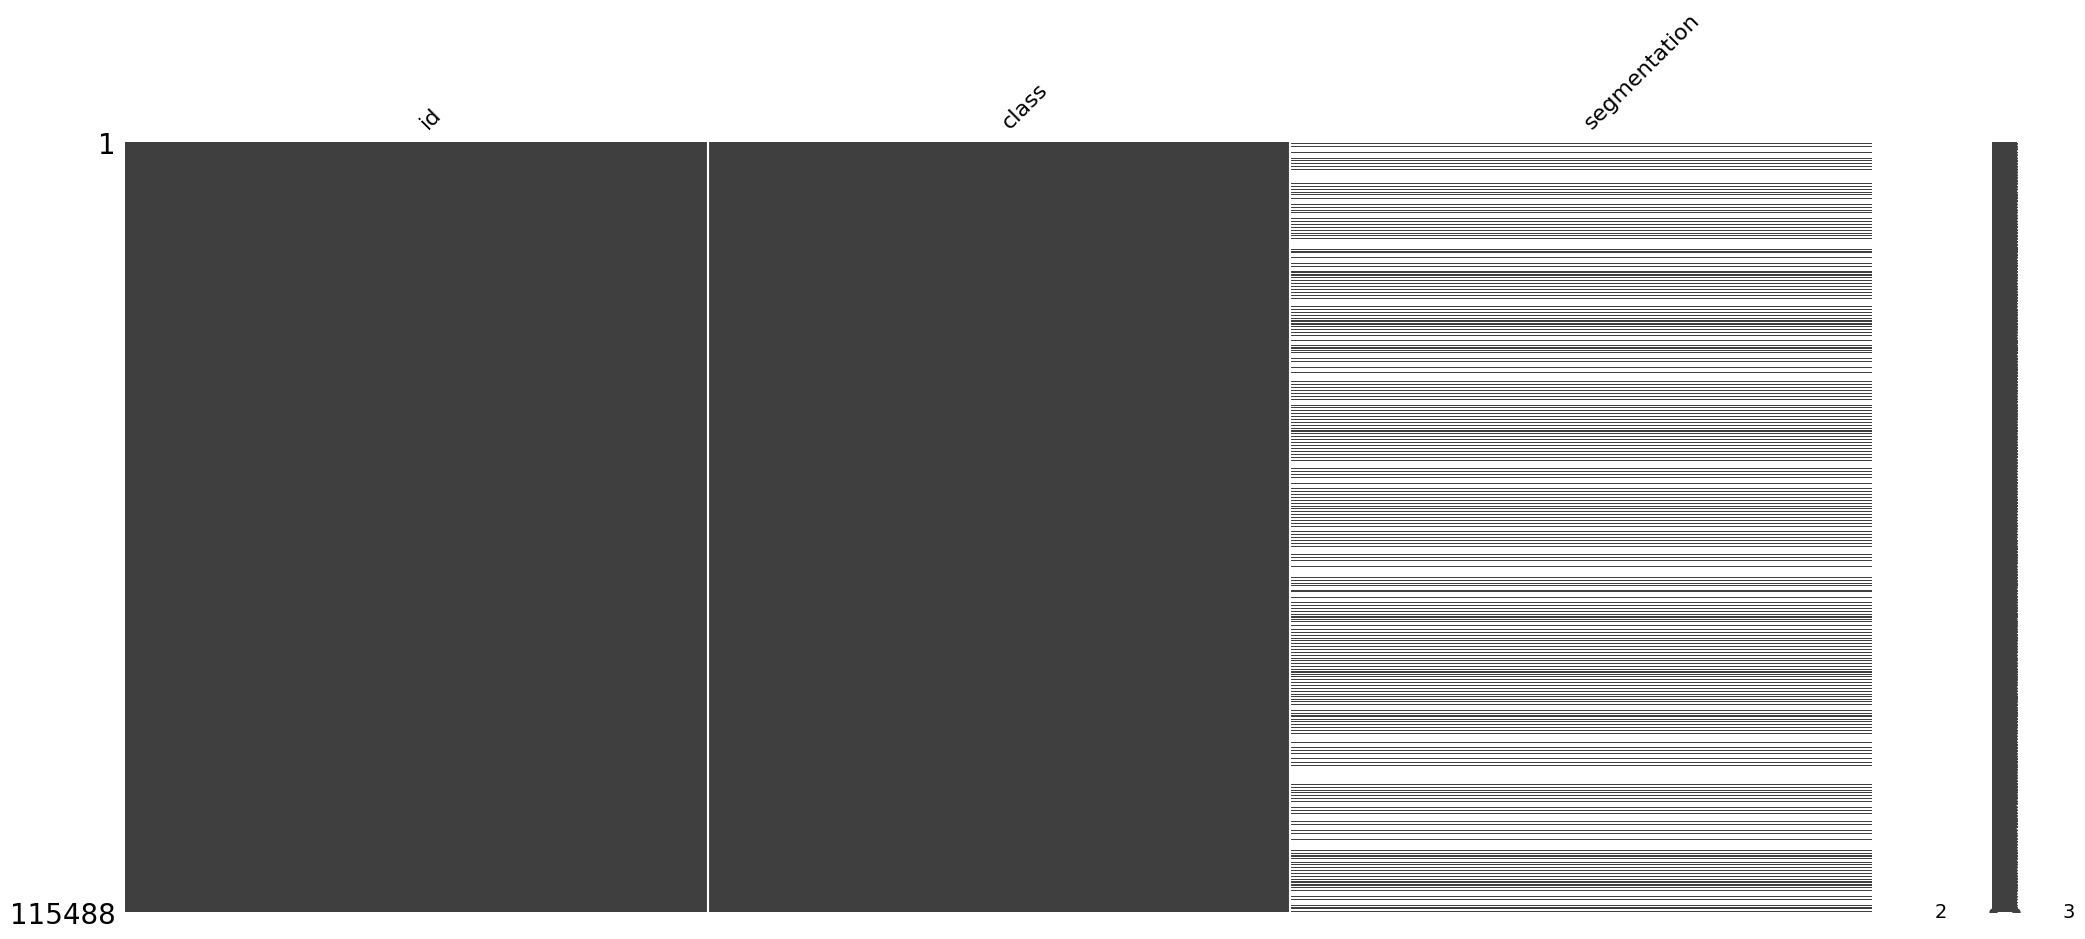

In [ ]:
# missing values
msno.matrix(df_cases);

In [ ]:
def construct_image_path(ids):
    """Get unique identifier for object and returns image paths"""
    image_paths = []
    for id in ids:
        case_ids, day_ids, _, slice_ids = id.split('_')
        scans_path = f'./train/{case_ids}/{case_ids}_{day_ids}/scans'

        image_path = [os.path.join(scans_path, slice_image) for slice_image in os.listdir(scans_path)]
        image_paths.append(image_path)

    return image_paths

In [ ]:
image_paths = construct_image_path(df_cases['id'])
print(f'Image paths length: {len(image_paths)}')

Image paths length: 115488


In [ ]:
def find_image_path(root_dir):
    case_ids = []
    day_ids = []
    image_paths = []

    for case_id in os.listdir(root_dir):
        case_dir = os.path.join(root_dir, case_id)
        if not os.path.isdir(case_dir):
            continue

        for day_id in os.listdir(case_dir):
            day_dir = os.path.join(case_dir, day_id)
            if not os.path.isdir(day_dir):
              continue

            slice_dir = os.path.join(day_dir, 'scans')
            if not os.path.isdir(slice_dir):
              continue

            for image_file in os.listdir(slice_dir):
                if image_file.endswith(".png"):
                    image_path = os.path.join(slice_dir, image_file)
                    image_paths.append(image_path)

    return image_paths * 3

In [ ]:
img_paths = find_image_path(root_dir)
print(f'Image paths length: {len(img_paths)}')

Image paths length: 115488


In [ ]:
ids = df_cases['id']
%timeit construct_image_path(ids)

40.5 s ± 3.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit find_image_path(root_dir)

90.7 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# create a DataFrame from the list of image paths
image_paths = find_image_path(root_dir)

data = {
    "image_path": image_paths
}

df_image_paths = pd.DataFrame(data)

# save to csv file
csv_filename = './data/image_paths.csv'
df_image_paths.to_csv(csv_filename, index=False)

In [ ]:
df_imag_paths = pd.read_csv('./data/image_paths.csv')
df_imag_paths

,image_path
0,./train/case78/case78_day26/scans/slice_0052_3...
1,./train/case78/case78_day26/scans/slice_0013_3...
2,./train/case78/case78_day26/scans/slice_0117_3...
3,./train/case78/case78_day26/scans/slice_0037_3...
4,./train/case78/case78_day26/scans/slice_0129_3...
...,...
115483,./train/case138/case138_day0/scans/slice_0129_...
115484,./train/case138/case138_day0/scans/slice_0135_...
115485,./train/case138/case138_day0/scans/slice_0110_...
115486,./train/case138/case138_day0/scans/slice_0046_...


In [ ]:
# create a dictionary to store counts for each size
size_counts = {}
unique_sizes = set()
image_paths = df_imag_paths['image_path']

for image_path in image_paths:
    # extract the size information from the path
    size_info = image_path.split("_")[3:5]
    size = "_".join(size_info)
    unique_sizes.add(size)
    # update the count for this size in the dictionary
    size_counts[size] = size_counts.get(size, 0) + 1

for size in unique_sizes:
  size_count = size_counts.get(f'{size}', 0)
  print(f"Number of images with size {size}: {size_count}")

Number of images with size 360_310: 33696
Number of images with size 266_266: 77760
Number of images with size 276_276: 3600
Number of images with size 234_234: 432


Concate the two dataframes horizontally

In [ ]:
# natural sort both data frames with the key argument
sorted_df_cases = df_cases.sort_values(by='id',
                           key=lambda x: np.argsort(index_natsorted(df_cases['id'])))

sorted_df_imag_path = df_image_paths.sort_values(by='image_path',
                                                 key=lambda x: np.argsort(index_natsorted(df_image_paths['image_path'])))

# concate the two dataframes horizontally, and use the index of sorted_df_cases for aligning the rows of sorted_df_imag_path, preserving the order
df = sorted_df_cases.join(sorted_df_imag_path.set_index(sorted_df_cases.index), rsuffix='_sorted_df_imag_path')
df.head()

# save to csv file
csv_filename = './data/df.csv'
df.to_csv(csv_filename, index=False)
df.head()

,id,class,segmentation,image_path
110304,case2_day1_slice_0001,large_bowel,NaN,./train/case2/case2_day1/scans/slice_0001_266_...
110305,case2_day1_slice_0001,small_bowel,NaN,./train/case2/case2_day1/scans/slice_0001_266_...
110306,case2_day1_slice_0001,stomach,NaN,./train/case2/case2_day1/scans/slice_0001_266_...
110307,case2_day1_slice_0002,large_bowel,NaN,./train/case2/case2_day1/scans/slice_0002_266_...
110308,case2_day1_slice_0002,small_bowel,NaN,./train/case2/case2_day1/scans/slice_0002_266_...


In [ ]:
def split_cases(csv_file, train_file, valid_file, test_file):
    """Split cases in a CSV file into train, valid, and test sets based on provided text files."""
    train_cases = read_cases_from_file(train_file)
    valid_cases = read_cases_from_file(valid_file)
    test_cases = read_cases_from_file(test_file)

    # create dictionaries to store data for train, validiation, and test sets
    train_data = {'id': [], 'class': [], 'segmentation': [], 'image_path': []}
    valid_data = {'id': [], 'class': [], 'segmentation': [], 'image_path': []}
    test_data = {'id': [], 'class': [], 'segmentation': [], 'image_path': []}

    # read and process the original CSV file
    with open(csv_file, 'r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        current_case_id = None
        current_data = []

        for row in csv_reader:
            case_id = row[0].split('_')[0]
            col = row[0].split(',')

            if case_id in train_cases:
                current_case_id = case_id
                train_data['id'].append(col[0])
                train_data['class'].append(col[1])
                train_data['segmentation'].append(col[2])
                train_data['image_path'].append(col[3])

            elif case_id in valid_cases:
                current_case_id = case_id
                valid_data['id'].append(col[0])
                valid_data['class'].append(col[1])
                valid_data['segmentation'].append(col[2])
                valid_data['image_path'].append(col[3])

            elif case_id in test_cases:
                current_case_id = case_id
                test_data['id'].append(col[0])
                test_data['class'].append(col[1])
                test_data['segmentation'].append(col[2])
                test_data['image_path'].append(col[3])

    # create DataFrames from the dictionaries
    train_df = pd.DataFrame(train_data)
    valid_df = pd.DataFrame(valid_data)
    test_df = pd.DataFrame(test_data)

    return train_df, valid_df, test_df

In [ ]:
csv_file = './data/df.csv'
train_file = f'{data_file_path}/train.txt'
validation_file = f'{data_file_path}/validation.txt'
test_file = f'{data_file_path}/test.txt'


train_df, validation_df, test_df = split_cases(csv_file,
                                               train_file,
                                               validation_file,
                                               test_file)

# save the train, validation, and test DataFrames to separate CSV files
train_df.to_csv('./data/train_data.csv', index=False)
validation_df.to_csv('./data/validation_data.csv', index=False)
test_df.to_csv('./data/test_data.csv', index=False)

In [ ]:
train_df = pd.read_csv('./data/train_data.csv')
validation_df = pd.read_csv('./data/validation_data.csv')
test_df = pd.read_csv('./data/test_data.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82320 entries, 0 to 82319
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            82320 non-null  object
 1   class         82320 non-null  object
 2   segmentation  24524 non-null  object
 3   image_path    82320 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [ ]:
# decode the 16-bit RLE encoded masks into binary masks (the location of foreground objects in segmentation)
def rle_to_mask(rle, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8)
    mask = mask.flatten()
    rle = rle.split()
    for i in range(0, len(rle), 2):
        start = int(rle[i]) - 1
        length = int(rle[i + 1])

        # set the region to white (foreground)
        mask[start:start + length] = 1
    return mask

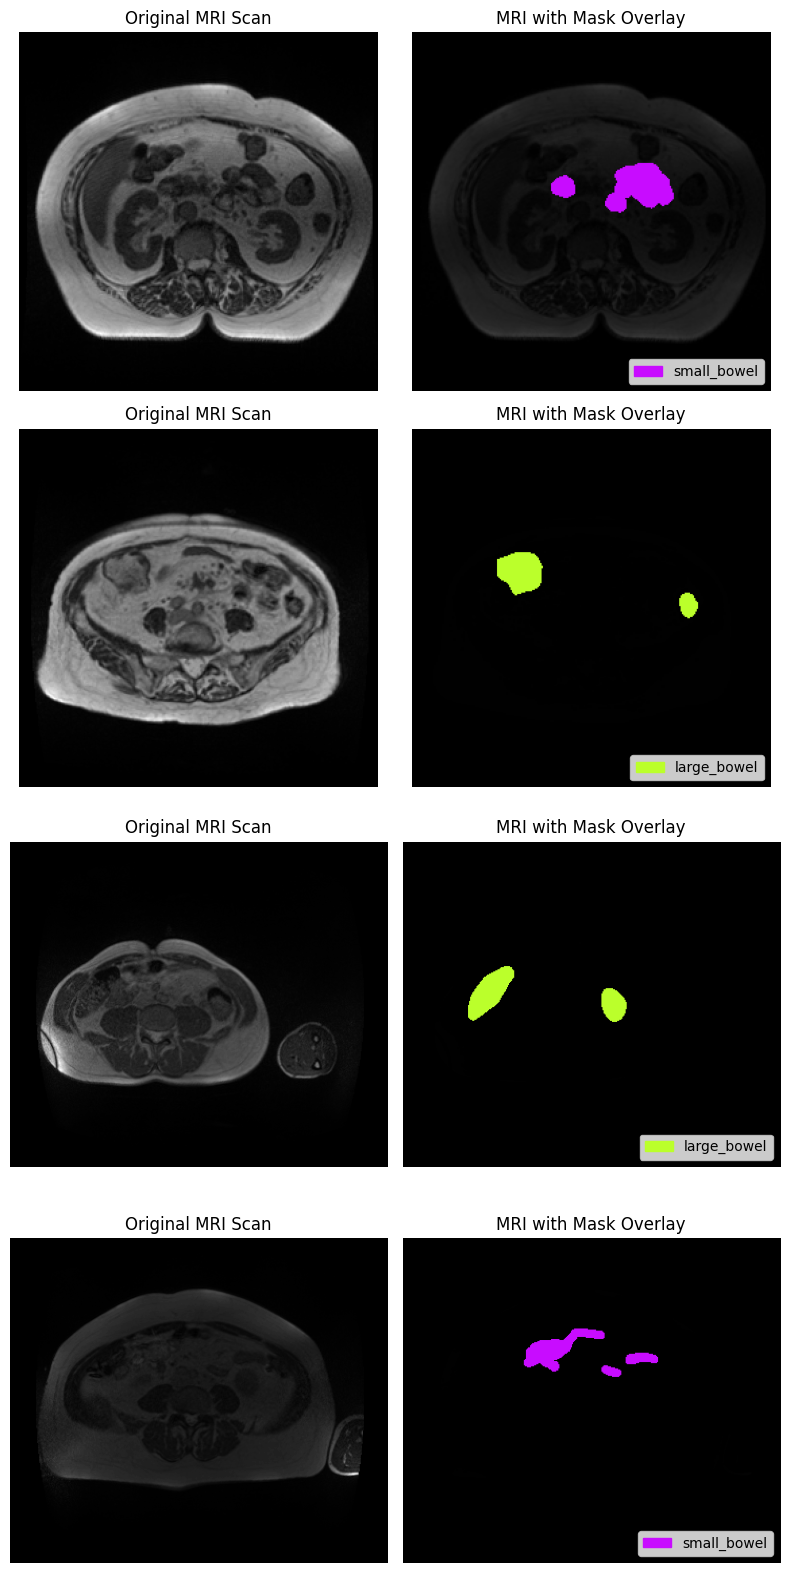

In [ ]:
train_df = pd.read_csv('./data/train_data.csv')

def show_random_samples(num_samples=9):

    train_data = train_df.dropna(subset=['segmentation'])
    # randomly select images
    selected_rows = train_data.sample(n=num_samples, replace=False, ignore_index=True)


    plt.figure(figsize=(8, num_samples * 4))
    for idx, (image_path, category, segmentation) in enumerate(zip(selected_rows['image_path'],
                                                                   selected_rows['class'],
                                                                   selected_rows['segmentation']), 1):
        # load the original MRI image
        original_img = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)

        image = cv2.imread(image_path)

        # decode the RLE encoded masks
        mask = rle_to_mask(segmentation, image.shape[:2])

        # define colors for different categories
        color = (187, 255, 43)  # default color
        if category == "small_bowel":
            color = (200, 12, 255)  # color for small_bowel
        elif category == "stomach":
            color = (255, 66, 113)  # color for stomach

        # apply the mask to the MRI image
        mask = mask.reshape(image.shape[:2])
        image[np.where(mask == 1)] = color

        # display the original MRI image
        plt.subplot(num_samples, 2, 2 * idx - 1)
        plt.axis('off')
        plt.title('Original MRI Scan')
        plt.imshow(original_img, cmap='gray')

        # display the MRI image with mask overlay
        plt.subplot(num_samples, 2, 2 * idx)
        plt.axis('off')
        plt.title('MRI with Mask Overlay')
        plt.imshow(image, cmap='gray')

        # create a custom legend handle
        legend_handle = mpatches.Patch(label=category, color=(color[0] / 255, color[1] / 255, color[2] / 255))

        # show legend
        plt.legend(handles=[legend_handle], loc='lower right')

    plt.tight_layout()
    plt.show()

show_random_samples(num_samples=4)

The dataset contains 85 cases with 38496 unique scan slices of organs represented in 16-bit grayscale PNG format. Each scan slices is repeted 3 times, with large_bowel, small_bowel, and stomach classes.
An empty segmentation entry represents no mask presented for the class in the MRI scan slice. The dataset has missing values.

The most common images size in the dataset is 266×266, and the rest are of sizes 310×360, 276×276, and 234×234 in descending order of occurrence.


Split the dataset to training, validation, and testing sets based on provided text files. (data folder)

*  train_data.csv: IDs, class, segmentation, and image_paths for training objects.

*   validation_data.csv: IDs, class, segmentation, and image_paths for validation objects.

*   test_data.csv: IDs, class, segmentation, and image_paths for test objects.




## 🟠 Custom dataset

In [ ]:
class GastroIntestinalDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        self.data = self.data.dropna(subset=['segmentation'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx, :]

        image = cv2.imread(sample.image_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        mask = rle_to_mask(sample.segmentation, image.shape)
        mask = mask.reshape(image.shape)

        if self.transform:
          image = self.transform(image)
          mask = self.transform(mask)

        return image, torch.Tensor(mask)

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor()])

In [ ]:
gi_dataset = GastroIntestinalDataset(csv_file='./data/train_data.csv',
                                     transform=transform)

len(gi_dataset)

24524

In [ ]:
train_set = GastroIntestinalDataset(csv_file='./data/train_data.csv', transform=transform)
valid_set = GastroIntestinalDataset(csv_file='./data/validation_data.csv', transform=transform)
test_set = GastroIntestinalDataset(csv_file='./data/test_data.csv', transform=transform)

## 🟠 Dataloader

In [ ]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=False)

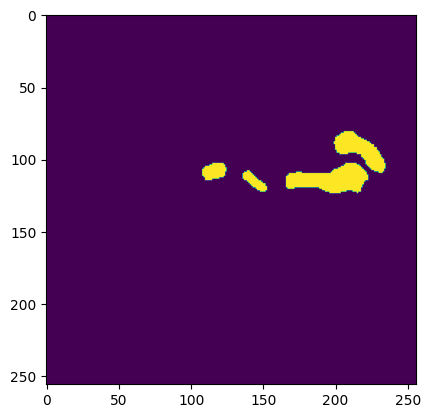

In [ ]:
x, y = next(iter(train_loader))
plt.imshow(y[0].squeeze());

# 🔴 **Model**

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
if wandb_enable:
    key_file = '/content/key'

    if os.path.exists(key_file):
        with open(key_file) as f:
            key = f.readline().strip()
        wandb.login(key=key)
    else:
        print("Key file does not exist. Please create the key file with your wandb API key.")

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model =

inputs, targets = next(iter(train_set))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model =
optimizer = torch.optim.SGD(model.parameters(), lr=, momentum=0.9)

In [ ]:
num_epochs = ...
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, ..., loss_fn, optimizer, metric, epoch)

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs =

for lr in [...]:
  print(f'LR={lr}')

  model =
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_set, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define train dataloader.

In [ ]:
set_seed(seed)
train_loader =

🔰 Define model.

In [ ]:
set_seed(seed)
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

# 🔴 **Segment**

🔰 Your mission is to write a `segmentation` function and use a test image to see the prediction of the model.

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()